In [1]:
# Cell 1: Imports and setup
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Configure plotting
plt.style.use('default')
sns.set_context("notebook", font_scale=1.1)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Imports complete!")

Imports complete!


In [2]:
# Cell 2: Database connection and data loading
def load_data_from_db(location=None, start_date=None, end_date=None):
    """
    Load swell readings from the database with optional filtering.
    
    Args:
        location (str, optional): Filter by location
        start_date (str, optional): Start date in YYYY-MM-DD format
        end_date (str, optional): End date in YYYY-MM-DD format
        
    Returns:
        pd.DataFrame: DataFrame with swell readings
    """
    conn = sqlite3.connect('/Users/mdietz/surfpy/swell_data.db')
    
    # Construct query
    query = "SELECT * FROM swell_readings"
    conditions = []
    params = []
    
    if location:
        conditions.append("location = ?")
        params.append(location)
    if start_date:
        conditions.append("timestamp >= ?")
        params.append(f"{start_date}T00:00:00")
    if end_date:
        conditions.append("timestamp <= ?")
        params.append(f"{end_date}T23:59:59")
    
    if conditions:
        query += " WHERE " + " AND ".join(conditions)
    
    # Add ordering
    query += " ORDER BY timestamp"
    
    # Load data
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    # Process timestamp
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        df['date'] = df['timestamp'].dt.date
    
    return df

# Load all data
all_data = load_data_from_db()
print(f"Loaded {len(all_data)} records from database")

# Basic data summary
if not all_data.empty:
    print(f"\nDate range: {all_data['timestamp'].min()} to {all_data['timestamp'].max()}")
    
    # Summary by source and location
    print("\nData by source:")
    print(all_data['source'].value_counts())
    
    print("\nData by location:")
    print(all_data['location'].value_counts())
    
    print("\nData by hour:")
    print(all_data['hour'].value_counts().sort_index())
else:
    print("No data found in database")

Loaded 177 records from database

Date range: 2025-05-20 09:50:00+00:00 to 2025-06-01 01:10:24+00:00

Data by source:
source
ndbc_buoy         90
surfline_lotus    87
Name: count, dtype: int64

Data by location:
location
steamer_lane    60
trestles        60
lido            57
Name: count, dtype: int64

Data by hour:
hour
0      4
1     36
9      9
10    10
13    40
15     9
16    10
19    40
21     8
22    11
Name: count, dtype: int64


In [3]:
# Cell 3: Basic data exploration
# Display first few rows
print("Sample data:")
print(all_data.head())

print("\nData types:")
print(all_data.dtypes)

print("\nBasic statistics for swell height:")
print(all_data['primary_swell_height'].describe())

Sample data:
    id          source      location                   buoy_id                 timestamp significant_height  primary_swell_height  primary_swell_period  primary_swell_direction  secondary_swell_height  secondary_swell_period  secondary_swell_direction wind_speed wind_direction                                           raw_data           created_at  hour        date
0  151       ndbc_buoy          lido                     44065 2025-05-20 09:50:00+00:00               None               1.41000              3.333333                328.00000                 1.20000                3.125000                  336.00000       None           None  {"date": "2025-05-20T09:50:00+00:00", "swell_c...  2025-05-21 01:26:53     9  2025-05-20
1  148  surfline_lotus          lido  5842041f4e65fad6a77089e2 2025-05-20 10:00:00+00:00               None               0.45476              3.000000                277.45459                 0.75938                6.000000                  176.44928

Available locations: ['lido', 'steamer_lane', 'trestles']


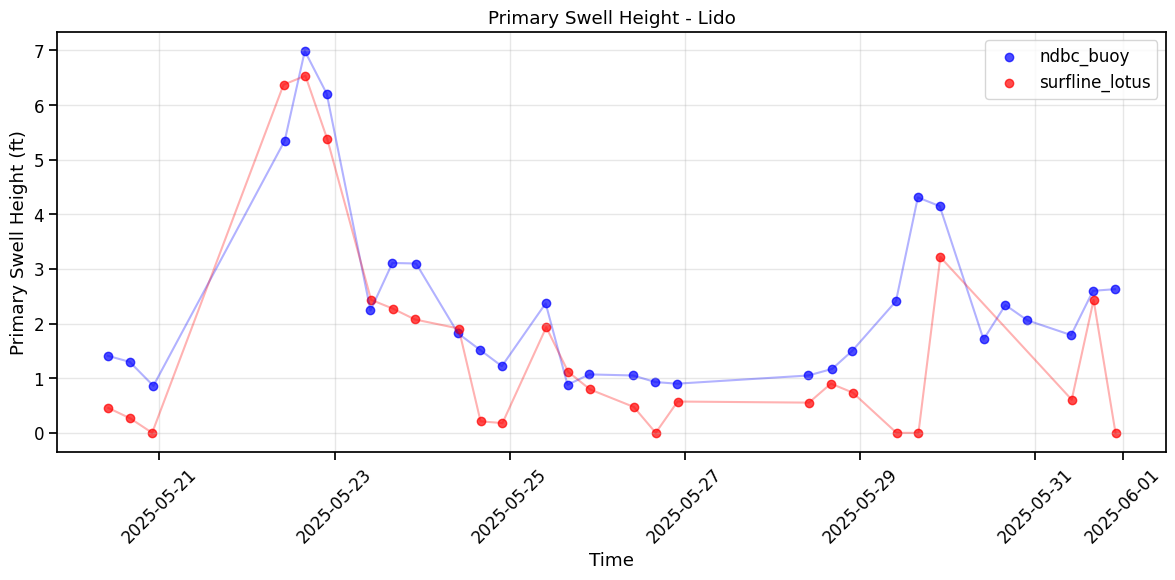

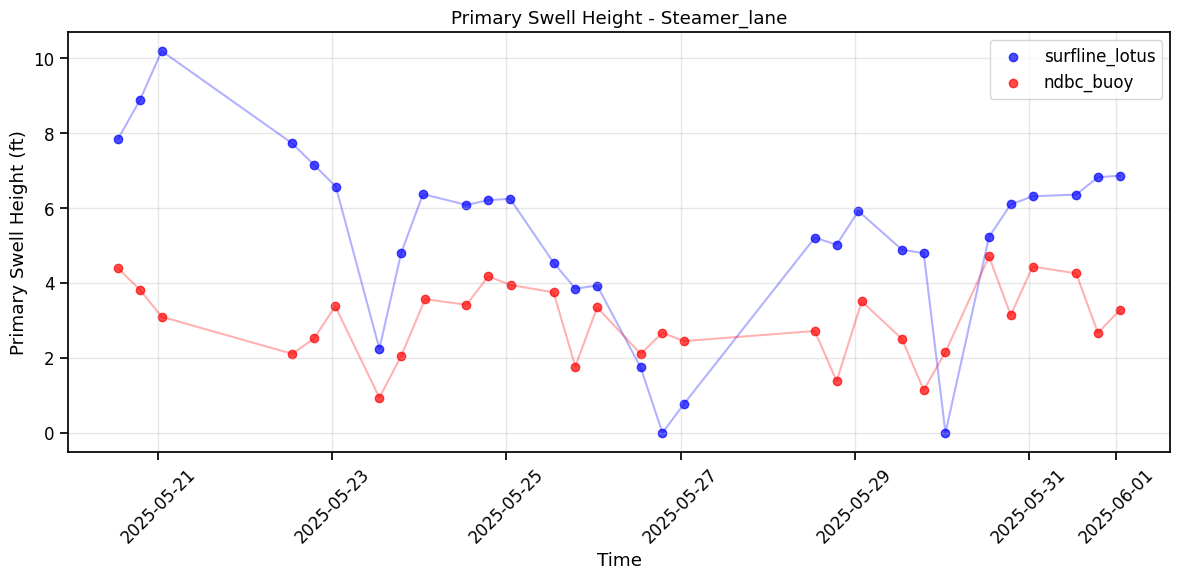

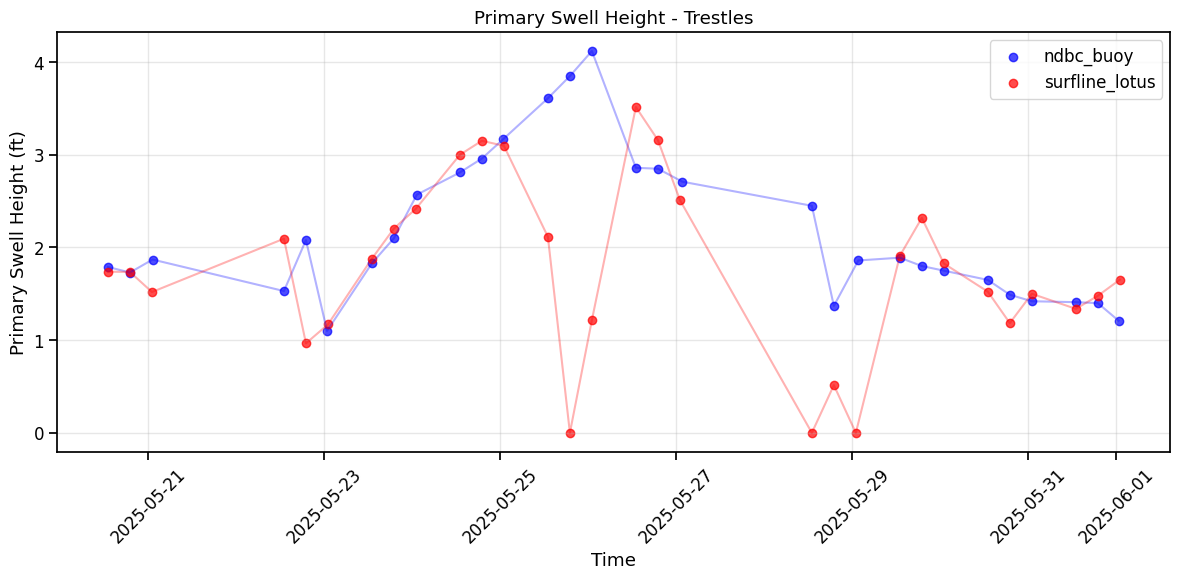

In [4]:
# Cell 4: Simple visualization function
def plot_swell_height_by_source(df, location=None):
    """Plot primary swell height by source for a specific location."""
    if location:
        df = df[df['location'] == location]
        title = f"Primary Swell Height - {location.capitalize()}"
    else:
        title = "Primary Swell Height - All Locations"
    
    if df.empty:
        print(f"No data available for plotting")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Plot each source
    sources = df['source'].unique()
    colors = ['blue', 'red', 'green', 'orange']
    
    for i, source in enumerate(sources):
        source_data = df[df['source'] == source]
        plt.scatter(source_data['timestamp'], source_data['primary_swell_height'], 
                   label=source, alpha=0.7, color=colors[i % len(colors)])
        
        # Connect points with lines for same source
        plt.plot(source_data['timestamp'], source_data['primary_swell_height'], 
                color=colors[i % len(colors)], alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Primary Swell Height (ft)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot for each location
locations = all_data['location'].unique()
print(f"Available locations: {list(locations)}")

for location in locations:
    plot_swell_height_by_source(all_data, location)

In [5]:
# Cell 5: Simple comparison function
def compare_sources_simple(df, location):
    """Simple comparison of sources for a specific location."""
    location_data = df[df['location'] == location]
    
    if location_data.empty:
        print(f"No data for {location}")
        return
    
    print(f"\n=== Analysis for {location.upper()} ===")
    
    # Group by hour to find matching time points
    sources = location_data['source'].unique()
    print(f"Sources available: {list(sources)}")
    
    # Summary stats by source
    print(f"\nSummary by source:")
    summary = location_data.groupby('source')['primary_swell_height'].agg(['count', 'mean', 'min', 'max'])
    print(summary)
    
    # Find hours where we have data from multiple sources
    hour_counts = location_data.groupby('hour')['source'].nunique()
    common_hours = hour_counts[hour_counts > 1].index
    
    if len(common_hours) > 0:
        print(f"\nHours with multiple sources: {list(common_hours)}")
        
        # For each common hour, show the differences
        for hour in common_hours:
            hour_data = location_data[location_data['hour'] == hour]
            print(f"\nHour {hour}:00:")
            for _, row in hour_data.iterrows():
                print(f"  {row['source']}: {row['primary_swell_height']:.1f}ft, "
                      f"{row['primary_swell_period']:.1f}s, {row['primary_swell_direction']:.0f}°")
    else:
        print(f"\nNo overlapping hours found for comparison")

# Run comparison for each location
for location in locations:
    compare_sources_simple(all_data, location)


=== Analysis for LIDO ===
Sources available: ['ndbc_buoy', 'surfline_lotus']

Summary by source:
                count      mean   min      max
source                                        
ndbc_buoy          30  2.335000  0.86  6.99000
surfline_lotus     27  1.534353  0.00  6.53707

Hours with multiple sources: [10, 16, 22]

Hour 10:00:
  surfline_lotus: 0.5ft, 3.0s, 277°
  surfline_lotus: 6.4ft, 7.0s, 103°
  ndbc_buoy: 5.3ft, 7.1s, 92°
  surfline_lotus: 2.4ft, 8.0s, 103°
  surfline_lotus: 1.9ft, 3.0s, 272°
  surfline_lotus: 1.9ft, 3.0s, 276°
  surfline_lotus: 0.5ft, 3.0s, 272°
  surfline_lotus: 0.6ft, 2.0s, 203°
  surfline_lotus: 0.0ft, 0.0s, 0°
  surfline_lotus: 0.6ft, 6.0s, 160°

Hour 16:00:
  surfline_lotus: 0.3ft, 3.0s, 53°
  surfline_lotus: 6.5ft, 8.0s, 103°
  surfline_lotus: 2.3ft, 9.0s, 109°
  surfline_lotus: 0.2ft, 16.0s, 141°
  surfline_lotus: 1.1ft, 3.0s, 260°
  surfline_lotus: 0.0ft, 0.0s, 0°
  surfline_lotus: 0.9ft, 9.0s, 136°
  ndbc_buoy: 1.2ft, 8.3s, 148°
  surfline_l